# Entrenamiento y predicción con Vertex AI

Este ejemplo muestra cómo entrenar, evaluar y desplegar un modelo de clasificación binaria con Vertex AI. También usaremos este modelo para generar predicciones.

Las dos primeras partes del tutorial explican cómo extraer los datos y prepararlos antes de entrenar su modelo.

La última parte del tutorial profundiza en el código de entrenamiento que se usa para este modelo.

## Conjunto de Datos

Este tutorial utiliza el conjunto de datos de ingresos del censo de los Estados Unidos proporcionado por el repositorio de aprendizaje automático de UC Irvine. Este conjunto de datos contiene información sobre personas de una base de datos del Censo de 1994, incluida la edad, la educación, el estado civil, la ocupación y si ganan más de $50,000 al año.

El conjunto de datos ahora existe en los conjuntos de datos públicos de BigQuery:

`bigquery-public-data.ml_datasets.census_adult_income`

## El objetivo del modelo

El objetivo es entrenar un modelo de clasificación binaria con BigQuery ML que prediga si una persona gana más de $50,000 al año (etiqueta de destino) en función de otra información del censo sobre la persona (características).

## Configuración del proyecto

In [1]:
PROJECT = 'bq-experiments-350102'

In [2]:
import os
os.environ['PROJECT'] = PROJECT

## Flujo de trabajo con un modelo con Vertex AI

In this section we will build a ScikitLearn model from scratch. We will perform the following steps:
- Preparación de datos
- Creación de modelo
- Entrenamiento modelo
- Evaluación del modelo
- Sirviendo el modelo

### Importaciones

In [3]:
#! pip3 install -U  -q --user tensorflow==2.5 \
#    tensorflow-data-validation==1.2 \
#    tensorflow-transform==1.2 \
#    tensorflow-io==0.18 

In [4]:
# Restart the kernel
import os

#if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
#    import IPython

#    app = IPython.Application.instance()
#    app.kernel.do_shutdown(True)

In [47]:
# Procesamiento de datos
import pandas as pd

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# BigQuery API
from google.cloud import bigquery 

# Scikit Learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

# BigQuery API
from google.cloud import bigquery 

# TensorFlow data validation
import tensorflow_data_validation as tfdv

# BigQuery API
from google.cloud import bigquery 

# GCP AI Platform
import google.cloud.aiplatform as aiplatform
from google.cloud import storage

# Otros
from datetime import datetime
import pickle 

# Mostrar versiones de software
print(__import__('sys').version)
print(pd.__version__)

import warnings
warnings.filterwarnings("ignore")

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
1.3.5


## Inicializar Vertex AI SDK

In [6]:
aiplatform.init(
       project='bq-experiments-350102',
       location='us-central1',
       experiment='census-example'
    )

## Preparación de datos

### Procesar columnas numéricas y categóricas
Los conjuntos de datos del censo contienen números y cadenas que necesitamos para convertir los datos de cadena en números para poder entrenar el modelo.

### Manejo de datos categóricos:

Para todas las columnas no numéricas que no sean TIMESTAMP, vamos a realiza una transformación de codificación one-hot. Esta transformación genera una característica separada para cada valor único en la columna.

### Crear cliente de BigQuery
Cree un cliente de BigQuery para agrupar la configuración necesaria para las solicitudes de API.

In [7]:
client = bigquery.Client(location='US', project=PROJECT)

## Crear un marco de datos de BigQuery

In [8]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
"""
dataframe = client.query(query).to_dataframe()

In [9]:
len(dataframe)

32561

In [10]:
dataframe.head(10)

,age,workclass,functional_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,27,Private,29261,HS-grad,9,Married-AF-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
1,47,Self-emp-not-inc,117865,HS-grad,9,Married-AF-spouse,Craft-repair,Husband,White,Male,0,0,90,United-States,<=50K
2,29,Private,95423,HS-grad,9,Married-AF-spouse,Transport-moving,Husband,White,Male,0,0,80,United-States,<=50K
3,26,Private,98155,HS-grad,9,Married-AF-spouse,Sales,Husband,White,Male,0,0,55,United-States,<=50K
4,30,Private,398827,HS-grad,9,Married-AF-spouse,Adm-clerical,Husband,White,Male,0,0,60,United-States,<=50K
5,35,Private,30565,HS-grad,9,Married-AF-spouse,Other-service,Wife,White,Female,0,0,40,United-States,>50K
6,43,Private,213844,HS-grad,9,Married-AF-spouse,Craft-repair,Wife,Black,Female,0,0,42,United-States,>50K
7,75,?,248833,HS-grad,9,Married-AF-spouse,?,Wife,White,Female,2653,0,14,United-States,<=50K
8,32,Private,281384,HS-grad,9,Married-AF-spouse,Other-service,Other-relative,White,Female,0,0,10,United-States,<=50K
9,19,Private,544091,HS-grad,9,Married-AF-spouse,Adm-clerical,Wife,White,Female,0,0,25,United-States,<=50K


In [11]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=dataframe,
    stats_options=tfdv.StatsOptions(
        label_feature="isFraud", sample_rate=1, num_top_values=50
    ),
)

In [12]:
tfdv.visualize_statistics(stats)

## Visualiza los datos

Pandas proporciona el método .corr. Se utiliza para encontrar la correlación por pares de todas las columnas en el marco de datos. Cualquier valor de na se excluye automáticamente. Para cualquier columna de tipo de datos no numérico en el marco de datos, se ignora.

El término correlación se refiere a una relación mutua o asociación entre cantidades.

Cuanto más cerca esté ρ de 1, más se asocia un aumento en una variable con un aumento en la otra. Por otro lado, cuanto más cerca esté ρ de -1, el aumento en una variable resultará en una disminución en la otra. Tenga en cuenta que si X e Y son independientes, entonces ρ está cerca de 0, ¡pero no al revés! En otras palabras, la correlación de Pearson puede ser pequeña incluso si existe una fuerte relación entre dos variables.

<AxesSubplot:>

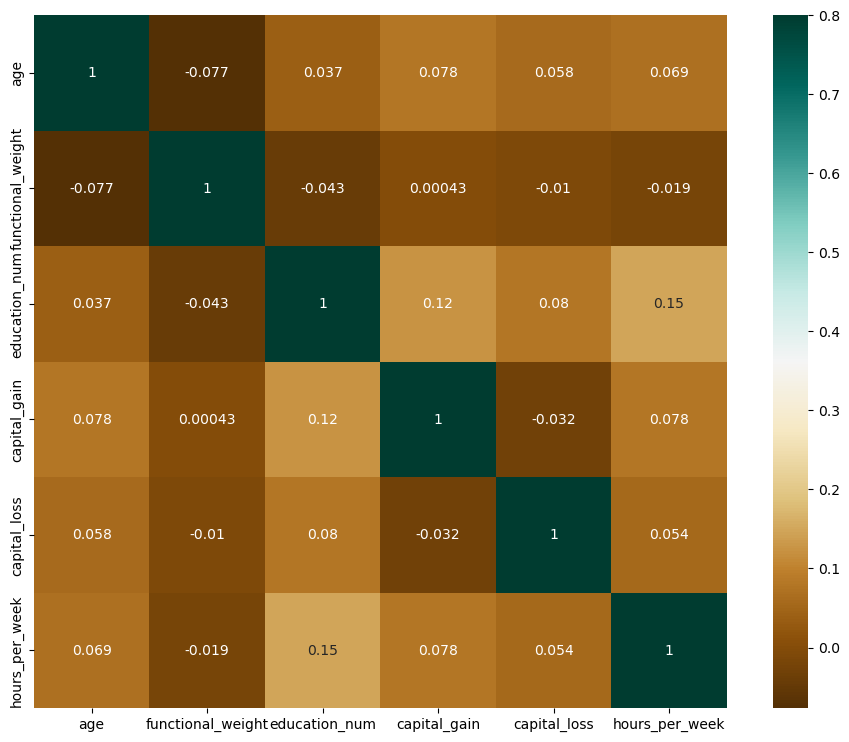

In [13]:
hmap = dataframe.corr(method='pearson')
plt.subplots(figsize=(12, 9))
sns.heatmap(hmap, vmax=0.8 ,annot=True, cmap="BrBG", square=True)

Cuando observamos las características numéricas, no tienen una fuerte correlación. Los atributos numéricos tienen un número significativo de valores únicos:

functional_weight, tiene más de 28,000 valores únicos para un conjunto de ~32,000 valores.
Esto puede indicar que esta característica podría no ser un predictor significativo.

#### Visualizar interacciones

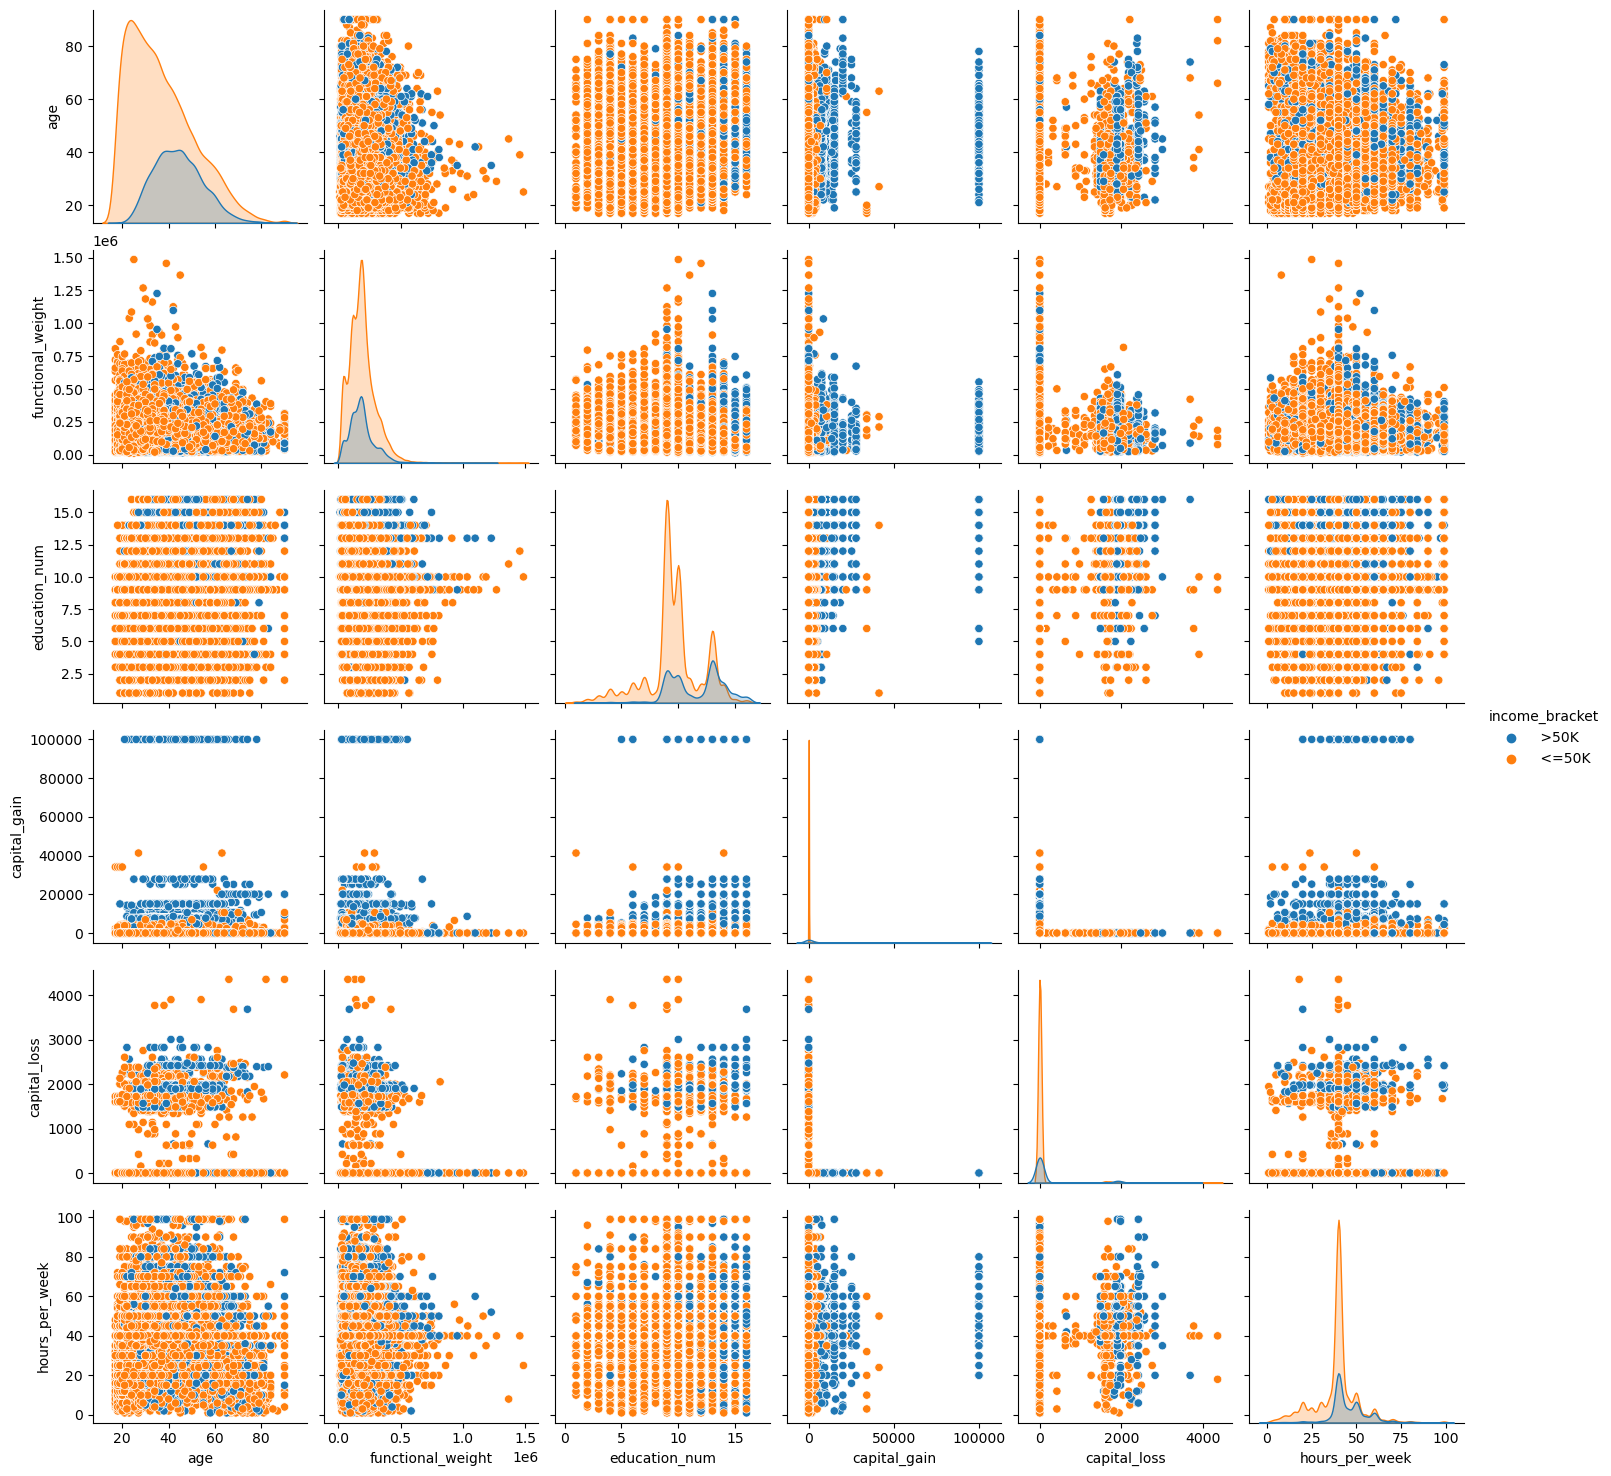

In [14]:
sns.pairplot(dataframe, hue='income_bracket')

En este gráfico puede ver las diferentes muestras y sus valores, esto es importante cuando está haciendo ingeniería de características.

### Recuento de >50K y <=50K

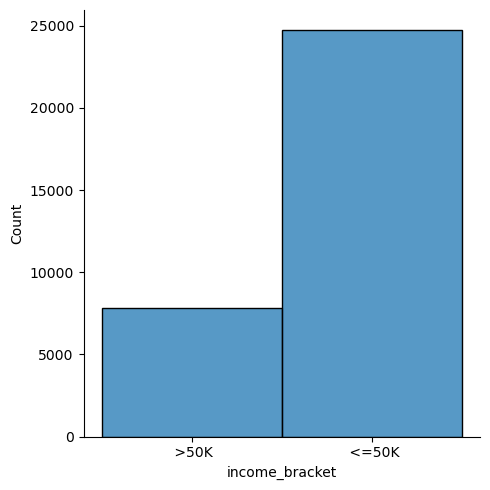

In [15]:
sns.displot(dataframe, x='income_bracket')

Hay un desequilibrio en la proporción de etiquetas, con 24720 valores para <=50K y 7841 para => 50K. sin embargo, el 24% del total debería ser suficiente para determinar la clase a través de patrones. En otros casos se pueden aplicar técnicas como boosting.

## Ingeniería de características
#### Análisis de datos numéricos
Haremos un análisis de datos numéricos para verificar las diferentes características y la correlación con el nivel de ingresos.

En las variables categóricas, hay tres atributos con valores desconocidos/faltantes:

workclass (6%)
occupation (6%)
native_country (2%)

In [16]:
# Comprobación de campos vacíos (NULO) O (?) y su porcentaje general
query = """
SELECT
  COUNTIF(workclass IS NULL 
    OR LTRIM(workclass) LIKE '?') AS workclass,
  ROUND(COUNTIF(workclass IS NULL 
    OR LTRIM(workclass) LIKE '?') / COUNT(workclass) * 100) 
    AS workclass_percentage,
  COUNTIF(occupation IS NULL 
    OR LTRIM(occupation) LIKE '?') AS occupation,  
  ROUND(COUNTIF(occupation IS NULL 
    OR LTRIM(occupation) LIKE '?') / COUNT(occupation) * 100) 
    AS occupation_percentage,
  COUNTIF(native_country IS NULL 
    OR LTRIM(native_country) LIKE '?') AS native_country,
  ROUND(COUNTIF(native_country IS NULL 
    OR LTRIM(native_country) LIKE '?') / COUNT(native_country) * 100) 
    AS native_country_percentage
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
"""
client.query(query).to_dataframe()

,workclass,workclass_percentage,occupation,occupation_percentage,native_country,native_country_percentage
0,1836,6.0,1843,6.0,583,2.0


In [17]:
# Comprobación de los valores de workclass.
dataframe['workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [18]:
# Comprobación de los valores de occupation.
dataframe['occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

In [19]:
# Comprobación de los valores de native_country.
dataframe['native_country'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

Echemos un vistazo a los siguientes atributos numéricos:

- **capital_gain** y **capital_loss** tienen cada uno cerca de 100 valores únicos, aunque la mayoría de sus instancias tienen valores cero.

- **capital_gain** tiene 72 % de instancias con valores cero para menos de 50 000 y 19 % de instancias con valores cero para > 50 000.

- **capital_loss** tiene 73 % de instancias con valores cero para menos de 50 000 y 21 % de instancias con valores cero para > 50 000.

- Esto implica que **capital_gain** o **capital_loss** tampoco serán predictores significativos.

In [20]:
# Evaluación de la educación
dataframe['education'].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

**educación** y **educación_número** son indicadores del mismo atributo y están completamente correlacionados con el mapeo directo, tiene sentido eliminar uno de ellos durante la selección de características.

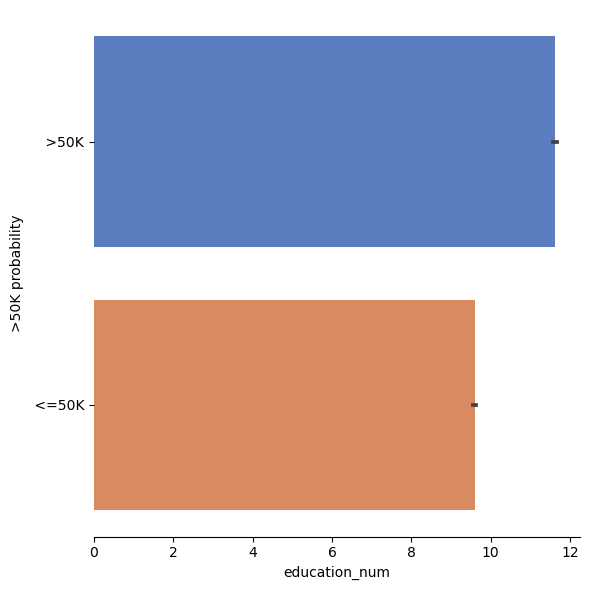

In [21]:
# Explore Núm. de Educación vs. Ingresos
g = sns.catplot(x="education_num", y="income_bracket", data=dataframe,kind="bar", 
                height = 6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")

In [22]:
# Explorando marital_status
dataframe['marital_status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital_status, dtype: int64

In [23]:
# Explorando relationship
dataframe['relationship'].value_counts()

 Husband           13193
 Not-in-family      8305
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: relationship, dtype: int64

Dado que la relationship y el marital_status son funciones que describen un estado similar, es posible que podamos eliminar la relationship y mantener marital_status y crear una nueva función con nuevos valores.

### Estandarice los datos para la convergencia de modelos

1. Para todas las columnas numéricas, vamos a y centra la columna en cero antes de pasarla al entrenamiento.

2. Omitimos las siguientes columnas para datos de entrenamiento:

['functional_weight', 'education', 'sex', 'relationship', 'race']

3. Convertiramos las características categóricas a numéricas con codificación one-hot.

4. Los valores desconocidos en **workclass** y **native_country** se reemplazan con Private y United States respectivamente.

Se eliminan las instancias con valores desconocidos para la **occupation*.

5. Elimina la **relationship** y usa **marital_status** de manera simplificada. (Puede usar Chi Square, que se usa comúnmente para probar relaciones entre variables categóricas (martial_status vs. relationship).

El resultado de la creación del modelo será un marco de datos vacío, esto es normal.

### Crear la división de prueba/entrenamiento

Crearemos un tren de prueba dividido con 80% para entrenamiento, 10% para prueba y 10% para validación.

### Datos de Entrenamiento

In [24]:
train_query = """
  SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country, 
      CASE 
        WHEN occupation IS NULL THEN 'unknown' 
        WHEN LTRIM(occupation) LIKE '?' THEN 'unknown'
        ELSE occupation
      END AS occupation,
      CASE 
        WHEN LTRIM(marital_status) IN 
          (
           'Never-married',
           'Divorced',
           'Separated',
           'Widowed'
          ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
           'Married-civ-spouse',
           'Married-spouse-absent',
           'Married-AF-spouse'
          ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,     
      hours_per_week,        
      income_bracket
    FROM   
      `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) < 8
      AND (occupation IS NOT NULL OR LTRIM(occupation) NOT LIKE '?%')
    GROUP BY  1, 2, 3, 4, 5, 6, 7, 8
"""
train_dataset = client.query(train_query).to_dataframe()

### Datos de Prueba

In [25]:
test_query = """
  SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,
      CASE 
        WHEN occupation IS NULL THEN 'unknown' 
        WHEN LTRIM(occupation) LIKE '?' THEN 'unknown'
        ELSE occupation
      END AS occupation,
      CASE 
        WHEN LTRIM(marital_status) IN 
          (
           'Never-married',
           'Divorced',
           'Separated',
           'Widowed'
          ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
           'Married-civ-spouse',
           'Married-spouse-absent',
           'Married-AF-spouse'
          ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,  
      hours_per_week,        
      income_bracket
    FROM   
      `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 8
      AND (occupation IS NOT NULL OR LTRIM(occupation) NOT LIKE '?%')
    GROUP BY  1, 2, 3, 4, 5, 6, 7, 8
"""
test_dataset = client.query(test_query).to_dataframe()

### Datos de Evaluación

In [26]:
eval_query = """
  SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,
      CASE 
        WHEN occupation IS NULL THEN 'unknown' 
        WHEN LTRIM(occupation) LIKE '?' THEN 'unknown'
        ELSE occupation
      END AS occupation,
      CASE 
        WHEN LTRIM(marital_status) IN 
          (
           'Never-married',
           'Divorced',
           'Separated',
           'Widowed'
          ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
           'Married-civ-spouse',
           'Married-spouse-absent',
           'Married-AF-spouse'
          ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,  
      hours_per_week,        
      income_bracket
    FROM   
      `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 9
      AND (occupation IS NOT NULL OR LTRIM(occupation) NOT LIKE '?%')
    GROUP BY  1, 2, 3, 4, 5, 6, 7, 8
"""
eval_dataset = client.query(eval_query).to_dataframe()

In [27]:
len(train_dataset), len(test_dataset), len(eval_dataset)

(20158, 3058, 2932)

In [28]:
train_dataset.head()

,age,workclass,native_country,occupation,marital_status,education_num,hours_per_week,income_bracket
0,27,Private,United-States,Craft-repair,Married,9,40,>50K
1,47,Self-emp-not-inc,United-States,Craft-repair,Married,9,90,<=50K
2,29,Private,United-States,Transport-moving,Married,9,80,<=50K
3,26,Private,United-States,Sales,Married,9,55,<=50K
4,30,Private,United-States,Adm-clerical,Married,9,60,<=50K


### Preparación de Datos

#### Escalar los valores numéricos

In [29]:
ss = StandardScaler()
train_dataset[['age','education_num','hours_per_week']]=  ss.fit_transform(train_dataset[['age','education_num','hours_per_week']])

#### Skew dummies de valores categóricos

In [30]:
train_dataset = pd.get_dummies(train_dataset, prefix=['wc', 'nc', 'ms','o'], columns=['workclass', 'native_country', 'marital_status','occupation'])

#### Label Encoding

In [31]:
le = LabelEncoder()
le.fit(train_dataset['income_bracket'])
le.classes_
train_dataset['income_bracket']=le.transform(train_dataset['income_bracket'])

#### Obtener valores de X e y

In [32]:
# Crear etiquetas 
y = train_dataset['income_bracket']

In [33]:
# Crear columnas de características
X = train_dataset.drop('income_bracket', axis=1)

## Entrenemiento del Modelo

### Iniciar Experimento

In [34]:
run_id = f"census-example-{datetime.now().strftime('%Y%m%d%H%M%S')}"
aiplatform.start_run(run_id)

Associating projects/402374189238/locations/us-central1/metadataStores/default/contexts/census-example-census-example-20221201191040 to Experiment: census-example


### Guardar consultas

In [35]:
metaparams = {}
metaparams["train_query"] = train_query
metaparams["test_query"] = test_query
metaparams["eval_query"] =eval_query
aiplatform.log_params(metaparams)

### Fit Modelo

In [36]:
max_iter = 120
random_state = 13
solver = 'newton-cg'

modelparams = {}
modelparams['max_iter'] = max_iter
modelparams['random_state'] = random_state
modelparams['solver'] = solver

aiplatform.log_params(modelparams)

model = LogisticRegression(max_iter=max_iter,solver=solver,random_state=random_state)
model = model.fit(X, y)

### Preparar datos de evaluación

In [37]:
eval_dataset[['age','education_num','hours_per_week']]=  ss.fit_transform(eval_dataset[['age','education_num','hours_per_week']])
eval_dataset = pd.get_dummies(eval_dataset, prefix=['wc', 'nc', 'ms','o'], columns=['workclass', 'native_country', 'marital_status','occupation'])
eval_dataset['income_bracket']=le.transform(eval_dataset['income_bracket'])

# Align columns
eval_dataset,train_dataset = eval_dataset.align(train_dataset, join='outer', axis=1, fill_value=0)
eval_dataset = eval_dataset[train_dataset.columns]

y_eval = eval_dataset['income_bracket']
X_eval = eval_dataset.drop('income_bracket', axis=1)

### Evaluar el modelo

In [38]:
y_pred = model.predict(X_eval)

In [39]:
labels=[0,1]
classification_metrics = {
        "matrix": confusion_matrix(y_eval, y_pred, labels=labels).tolist(),
        "labels": labels
        }

In [40]:
print(classification_metrics)

{'matrix': [[2045, 169], [405, 313]], 'labels': [0, 1]}


<AxesSubplot:>

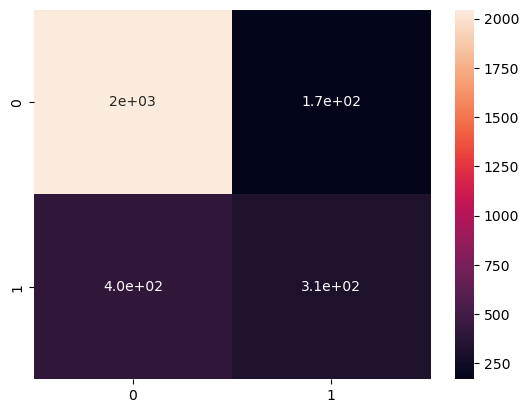

In [41]:
sns.heatmap(classification_metrics['matrix'], annot=True)

In [42]:
f1 = f1_score(y_eval, y_pred, average='macro')
print('f1 score: {}'.format(f1))

f1 score: 0.6992981703830761


In [43]:
aiplatform.log_metrics({"f1_score": f1})

In [44]:
aiplatform.end_run()

## Guarde el artefacto modelo

In [48]:
# Save local PICKLE file
FILE_NAME = 'model.pkl'
pickle.dump(model, open(FILE_NAME, 'wb'))

# Upload model artifact to Cloud Storage
AIP_BUCKET = 'bq-experiments-models'
BLOB_PATH = AIP_BUCKET+"/models/"
ARTIFACT_GCS_PATH = f'gs://{BLOB_PATH}'
storage_path = os.path.join(ARTIFACT_GCS_PATH, FILE_NAME)
blob = storage.blob.Blob.from_string(storage_path, client=storage.Client())
blob.upload_from_filename(FILE_NAME)

## Agregar modelo al registro

In [49]:
!gcloud ai models upload \
  --region=us-central1 \
  --display-name=census-example\
  --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest \
  --artifact-uri=gs://bq-experiments-models/models/ \
  --description='census example' \
  --version-aliases='v01'

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [4789599438026833920]...done.                            


## Crear un endpoint

In [50]:
!gcloud ai endpoints create \
  --region=us-central1 \
  --display-name=census-example-ep1

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [4801421387048681472]...done.                            
Created Vertex AI endpoint: projects/402374189238/locations/us-central1/endpoints/3814166254336344064.


## Desplegar el Modelo

In [ ]:
!gcloud ai endpoints deploy-model 3814166254336344064 \
  --region=us-central1 \
  --model=5990634128356147200 \
  --display-name=census-example \
  --machine-type=n1-standard-4 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [1700130093650673664]...⠹                                

## Hacer predicciones